In [40]:
import numpy as np
import cv2
import pywt
import matplotlib.pyplot as plt
import sys
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from math import sqrt
import importlib
sys.path.append(os.path.join(os.getcwd(), 'common'))
from utility import wpsnr, get_locations, modular_alpha, create_perceptual_mask_1, create_perceptual_mask_2
from detection import similarity



In [42]:
#List of different attacks
from sklearn.metrics import roc_curve, auc

import random

#this seed was set just to make you obtain the same result
random.seed(3)
def awgn(img, std, seed):
  mean = 0.0   # some constant
  #np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return attacked

def blur(img, sigma):
  from scipy.ndimage.filters import gaussian_filter
  attacked = gaussian_filter(img, [sigma, sigma])
  return attacked

def sharpening(img, sigma, alpha):
  import scipy
  from scipy.ndimage import gaussian_filter
  import matplotlib.pyplot as plt

  #print(img/255)
  filter_blurred_f = gaussian_filter(img, sigma)

  attacked = img + alpha * (img - filter_blurred_f)
  return attacked

def median(img, kernel_size):
  from scipy.signal import medfilt
  attacked = medfilt(img, kernel_size)
  return attacked

def resizing(img, scale):
  from skimage.transform import rescale
  x, y = img.shape
  attacked = rescale(img, scale)
  attacked = rescale(attacked, 1/scale)
  attacked = attacked[:x, :y]
  return attacked

def jpeg_compression(img, QF):
  from PIL import Image
  img = Image.fromarray(img)
  img = img.convert('L')
  img.save('tmp.jpg',"JPEG", quality=QF)
  attacked = Image.open('tmp.jpg')
  attacked = np.asarray(attacked,dtype=np.uint8)
  os.remove('tmp.jpg')

  return attacked

In [77]:
def get_locations(subband):
    sign = np.sign(subband)
    abs_subband = abs(subband)
    locations = np.argsort(-abs_subband, axis=None) # - sign is used to get descending order
    locations = locations.reshape(subband.shape) 
    return abs_subband, sign, locations

def modular_alpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayLayer.reverse()
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]


def embedding(original_image, watermark, alpha, max_layer, v='m'):
    coeffs = pywt.wavedec2(original_image, wavelet='haar', level=max_layer)
    LL, *details = coeffs
    for layer in range(max_layer):
        watermark_bits = watermark.reshape(32,32)
        LH, HL, HH = details[layer]
        if v == 'a':
            LH[:32, :32] += modular_alpha(layer=layer,theta=0, alpha=alpha) * watermark_bits
            HL[:32, :32] += modular_alpha(layer=layer,theta=2, alpha=alpha) * watermark_bits
            HH[:32, :32] += modular_alpha(layer=layer,theta=1, alpha=alpha) * watermark_bits
        else:
            LH[:32, :32] *= (1 + modular_alpha(layer=layer, theta=0, alpha=alpha) * watermark_bits)
            HL[:32, :32] *= (1 + modular_alpha(layer=layer, theta=0, alpha=alpha) * watermark_bits)
            HH[:32, :32] *= (1 + modular_alpha(layer=layer, theta=0, alpha=alpha) * watermark_bits)
        details[layer] = (LH, HL, HH)
        
    coeffs = [LL] + details

    watermarked_image = pywt.waverec2(coeffs, wavelet='haar')
    return np.clip(watermarked_image, 0, 255).astype(np.uint8)



In [81]:
def detection(original_image, watermarked_image, alpha, max_layer, v='m'):
    mark = np.load('ammhackati.npy')
    coeffs_cover = pywt.wavedec2(original_image, wavelet='haar', level=max_layer)
    coeffs_watermarked = pywt.wavedec2(watermarked_image, wavelet='haar', level=max_layer)
    LL_cover, *details_cover = coeffs_cover
    LL_wm, *details_wm = coeffs_watermarked

    extracted_wm = np.zeros((32,32), dtype=np.uint8)
    watermarks = []
    for layer in range(max_layer):
        LH_cover, HL_cover, HH_cover = details_cover[layer]
        LH_wm, HL_wm, HH_wm = details_wm[layer]
        if v == 'a':
            extracted_wm = (LH_wm[:32, :32] - LH_cover[:32, :32]) / modular_alpha(layer, 0, alpha)
            watermarks.append(extracted_wm)
            extracted_wm = (HL_wm[:32, :32] - HL_cover[:32, :32]) / modular_alpha(layer, 2, alpha)
            watermarks.append(extracted_wm)
            extracted_wm = (HH_wm[:32, :32]  - HH_cover[:32, :32]) / modular_alpha(layer, 1, alpha)
            watermarks.append(extracted_wm)
        else:
            extracted_wm = (LH_wm[:32, :32] - LH_cover[:32, :32]) / (modular_alpha(layer, 0, alpha) * LH_cover[:32, :32])
            watermarks.append(extracted_wm)
            extracted_wm = (HL_wm[:32, :32] - HL_cover[:32, :32]) / (modular_alpha(layer, 2, alpha) * HL_cover[:32, :32])
            watermarks.append(extracted_wm)
            extracted_wm = (HH_wm[:32, :32]  - HH_cover[:32, :32]) / (modular_alpha(layer, 1, alpha) * HH_cover[:32, :32])
            watermarks.append(extracted_wm)
    
    sim = []
    for i in range(len(watermarks)):
        watermarks[i] = watermarks[i].flatten()
        sim.append(similarity(watermarks[i], mark))

    sim = max(sim)

    print(sim)

    
    



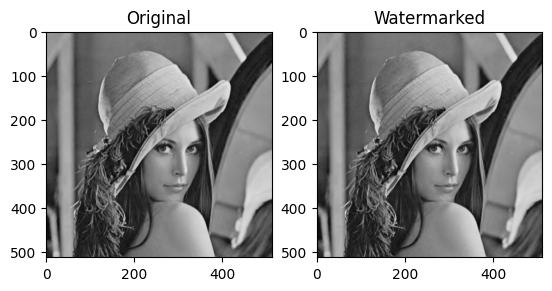

In [85]:
img = cv2.imread('lena_grey.bmp', 0)
mark = np.load('ammhackati.npy')
alpha = 8
layer = 3
wm = embedding(img, mark, alpha=alpha, max_layer=layer, v='a')

plt.subplot(121)
plt.title('Original')
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.title('Watermarked')
plt.imshow(wm, cmap='gray')


In [83]:
print(wpsnr(img, wm))

detection(img, wm, alpha, layer)
attacked = blur(wm, 0.95)
detection(img, attacked, alpha, layer)
print(wpsnr(attacked, wm))


46.768812281781166
0.858795737082111
0.05250880098599632


/tmp/ipykernel_3305/3756673364.py:16: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


44.24287978952216
